In [1]:
import re
from functools import reduce
from collections import Counter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

from datasets.fbp_dataset import FBPDataset
from datasets.fbp_dataset import load_texts
from datasets.processing_funcs import PIPELINE

nltk.download("stopwords")
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zumo0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
documents, tags = load_texts("./input/feedback-prize-2021/", PIPELINE, 1)
encoder = OrdinalEncoder()
label_unique = np.array(tags["discourse_type"].unique())
encoder.fit(label_unique.reshape(-1, 1))
dataset = FBPDataset(documents, tags, encoder, True)


Loading Dataset: 100%|██████████| 15594/15594 [03:20<00:00, 77.66it/s] 


In [3]:
tags.sample(3)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,box_center,box_length
92475,9DF8A166D993,1614785194839,1014,1156,its wrong to the country because everyone has ...,Claim,Claim 3,173 174 175 176 177 178 179 180 181 182 183 18...,0.521158,0.064588
26499,2E5E8300A20D,1619640998442,408,519,Another reason you should join is because you ...,Claim,Claim 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,0.436214,0.094650
81740,481D89A228B3,1621616766849,290,354,"Driving is not suppose to be fun, driving is s...",Evidence,Evidence 1,50 51 52 53 54 55 56 57 58 59 60 61 62,0.140041,0.033195


# General

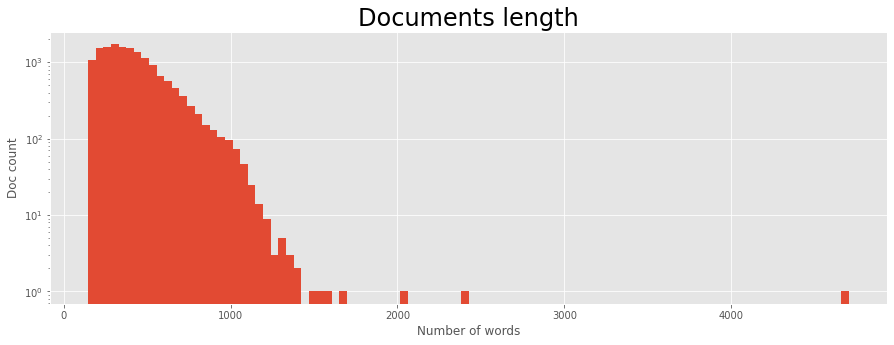

In [4]:
doc_len = documents.map(lambda x: len(x.split()))
plt.figure(figsize=(15, 5))
doc_len.hist(bins=100)
plt.yscale("log")
plt.title("Documents length", fontsize=24)
plt.xlabel("Number of words")
plt.ylabel("Doc count")
plt.savefig("figures/documents_length.pdf")
plt.show()

# Classes

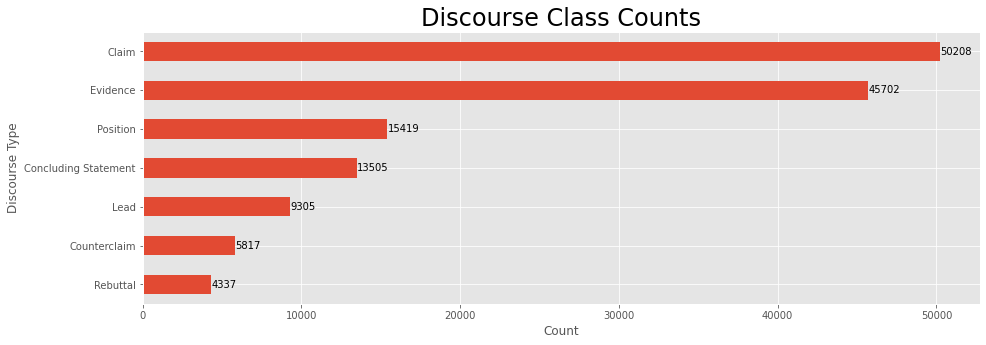

In [16]:
ax = (
    tags.groupby(by="discourse_type")[["id"]]
    .count()
    .sort_values("id")
    .plot(
        kind="barh",
        figsize=(15, 5),
        xlabel="Discourse Type",
        legend=False,
    )
)
assert isinstance(ax, plt.Axes)
ax.set_title("Discourse Class Counts", fontsize=24)
ax.set_xlabel("Count")
ax.bar_label(ax.containers[0], label_type="edge")
plt.savefig("figures/class_counts.pdf")
plt.show()


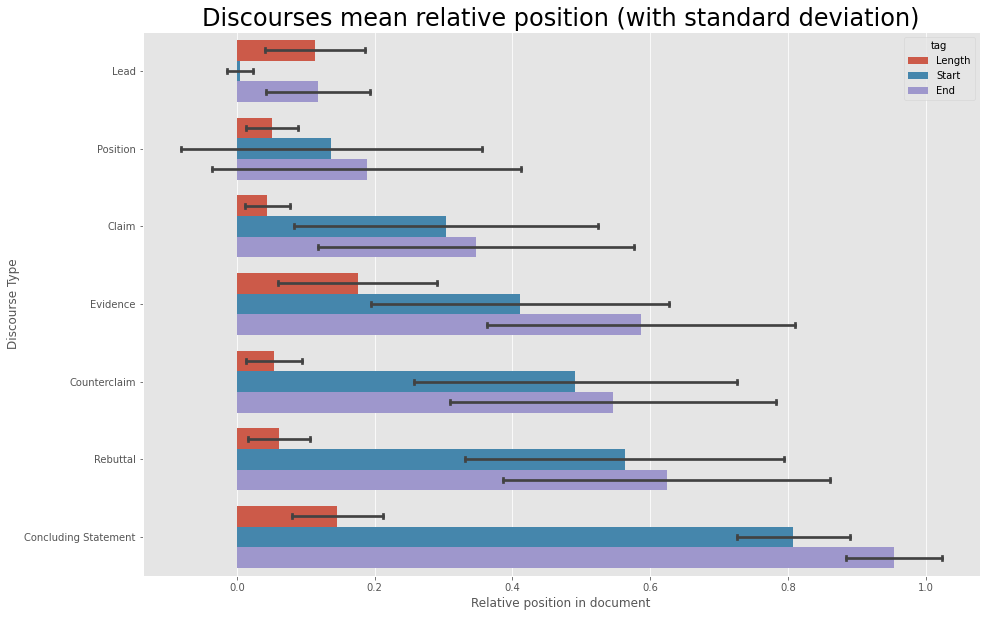

In [15]:
# Realive positions
tmp = tags[["discourse_type"]].copy()
tmp["discourse_len"] = tags["box_length"]
tmp["discourse_start"] = tags["box_center"] - tags["box_length"] / 2
tmp["discourse_end"] = tags["box_center"] + tags["box_length"] / 2

tmp_end = tmp[["discourse_type", "discourse_end"]].copy()
tmp_end.columns = ["discourse_type", "position"]
tmp_end["tag"] = "End"

tmp_start = tmp[["discourse_type", "discourse_start"]].copy()
tmp_start.columns = ["discourse_type", "position"]
tmp_start["tag"] = "Start"

tmp_len = tmp[["discourse_type", "discourse_len"]].copy()
tmp_len.columns = ["discourse_type", "position"]
tmp_len["tag"] = "Length"

tmp_cat = pd.concat([tmp_len, tmp_start, tmp_end])

plot_order = (
    tmp.groupby("discourse_type")["discourse_start"].mean().sort_values().index.values
)

plt.figure(figsize=(15, 10))
sns.barplot(
    x="position",
    y="discourse_type",
    hue="tag",
    data=tmp_cat,
    ci="sd",  # type: ignore
    capsize=0.05,
    order=plot_order,
)

plt.title("Discourses mean relative position (with standard deviation)", fontsize=24)
plt.ylabel("Discourse Type")
plt.xlabel("Relative position in document")
plt.savefig("figures/discourse_rel_pos.pdf")
plt.show()

# Gaps

In [10]:
all_gaps = []

for group_id, group in tags.groupby(by='id'):
    end = -1
    ordered = group.sort_values(by="discourse_start")
    for _, row in ordered.iterrows():
        init = row.discourse_start
        diff = init - end - 1
        end = row.discourse_end
        if diff > 0:
            all_gaps.append(diff)

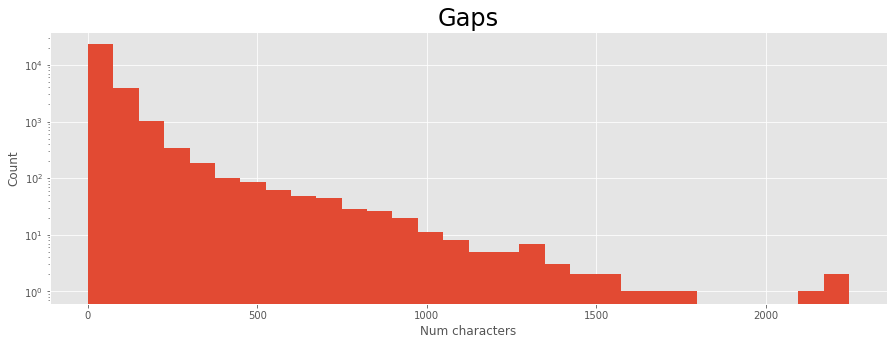

In [14]:
pd.Series(all_gaps).hist(bins=30, figsize=(15, 5))
plt.title("Gaps", fontsize=24)
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("Num characters")
plt.savefig("figures/gaps.pdf")
plt.show()

# Number of queries

In [12]:
grouped = tags.groupby(by="id")

arg_seg = np.zeros(len(grouped))
non_arg = np.zeros(len(grouped))
for j, (k, gp) in enumerate(grouped):
    arg_seg[j] = len(gp)
    for i in range(len(gp) - 1):
        pred_str1 = gp["predictionstring"].iloc[i].split()
        pred_str2 = gp["predictionstring"].iloc[i + 1].split()
        start = int(pred_str1[-1])
        end = int(pred_str2[0])
        if start + 1 != end:
            non_arg[j] += 1

seg = non_arg + arg_seg

print(f"The maximum number of units for document is : {int(np.max(seg))}")
print(f"The maximum number of argumentative units for document is : {int(np.max(arg_seg))}")


The maximum number of units for document is : 32
The maximum number of argumentative units for document is : 26


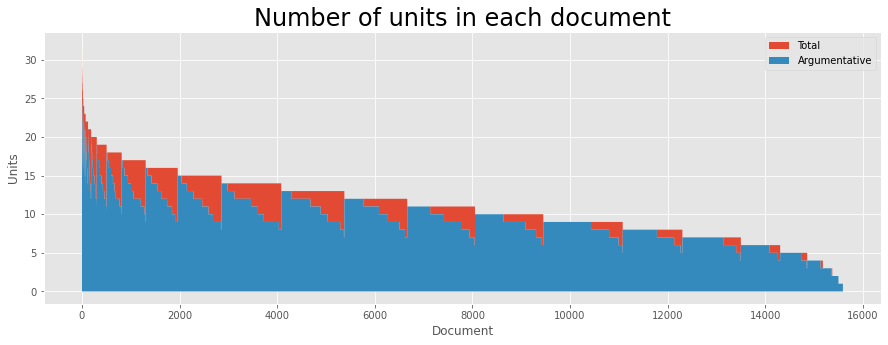

In [13]:
# Plot the distribution of the number of argumentative unit for each document
x = range(len(dataset))

idxs = np.flip(np.argsort(seg))
seg_sort = seg[idxs]
arg_seg_sort = arg_seg[idxs]
non_arg_sort = non_arg[idxs]

value = seg_sort[0]
new_idxs = np.empty_like(idxs)
start = 0
for end, val in enumerate(np.roll(seg_sort, -1), start=1):
    if val == value:
        continue
    to_sort = arg_seg_sort[start: end]
    s = np.flip(np.argsort(to_sort))
    new_idxs[start: end] = idxs[start: end][s]
    start = end
    value = val

seg_sort = seg[new_idxs]
arg_seg_sort = arg_seg[new_idxs]
non_arg_sort = non_arg[new_idxs]

plt.figure(figsize=(15, 5))
plt.fill_between(x, seg_sort, arg_seg_sort, label="Total")
plt.fill_between(x, arg_seg_sort, 0, label="Argumentative")
plt.xlabel("Document")
plt.ylabel("Units")
plt.title("Number of units in each document", fontsize=24)
plt.legend()
plt.savefig("figures/units_per_doc_count.pdf")
plt.show()

# Class Correlation

In [8]:
REPLACE_BY_SPACE_RE = re.compile("[.,;!?']")
STOPWORDS = set(nltk.corpus.stopwords.words("english"))


def remove_stopwords(text: str) -> str:
    return " ".join([x for x in text.split() if x and x not in STOPWORDS])

def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(" ", text)


NEW_PIPELINE = PIPELINE + [replace_special_characters, remove_stopwords]


def get_words(gp):
    group = gp["discourse_text"]
    words = []
    for i in range(len(group)):
        words += reduce(lambda txt, f: f(txt), NEW_PIPELINE, group.iloc[i]).split()
    return words
    
counted = {key: Counter(get_words(gp)) for key, gp in tags.groupby(by="discourse_type")}
labels = list(counted.keys())


def correlation(word: str) -> np.ndarray:
    nums = [counted[key].get(word, 0) for key in labels]
    corr = [n / len(counted[k]) for n, k in zip(nums, labels)]
    idf = np.log10(len(dataset) / sum(nums))
    return np.array(corr) * idf


words = [set(counts.keys()) for counts in counted.values()]
word_list = list(set().union(*words))

matrix = np.zeros((len(word_list), len(labels)))
for i, w in enumerate(word_list):
    matrix[i, :] = correlation(w)

weights = pd.DataFrame(matrix, columns=labels, index=word_list)

limits = weights.max() - weights.std()
keep = []
for i, data in weights.iterrows():
    if (data > limits).any():
        keep.append(i)
df_filt = weights.loc[keep]
df_filt["order"] = ((df_filt - weights.mean()) / weights.std()).sum(axis=1)
df_filt = df_filt.sort_values(by="order", ascending=False).drop("order", axis=1)

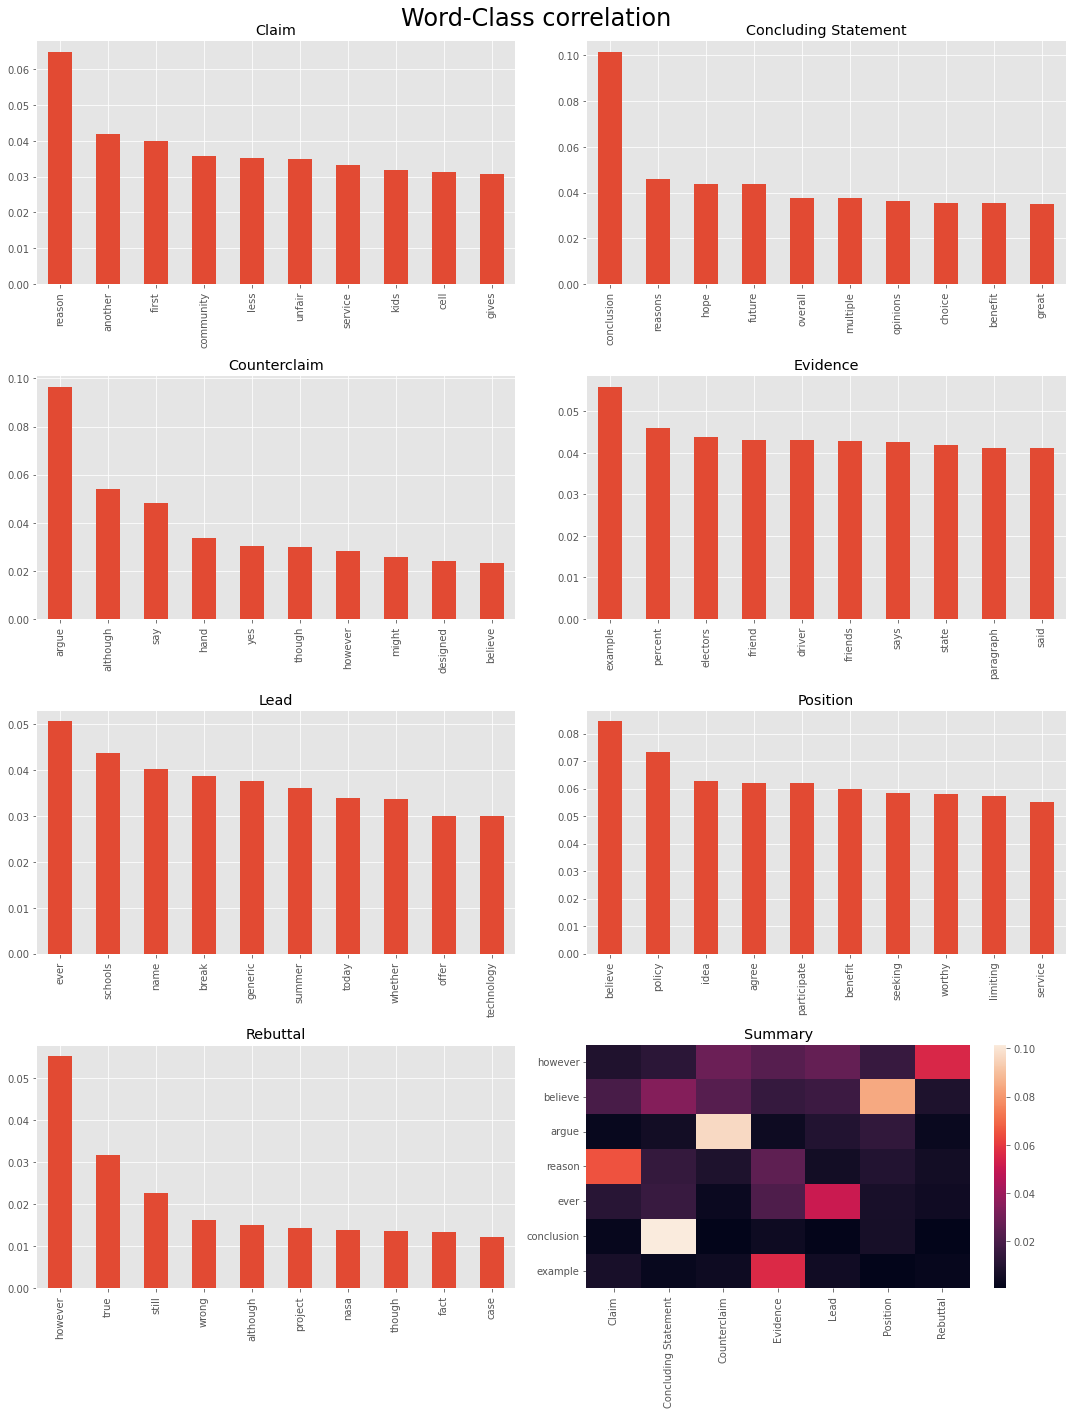

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

for i, col in enumerate(weights.columns):
    df = weights[[col]].sort_values(by=[col], ascending=False)
    df = df[col].head(10).plot(kind="bar", title=col, ax=axs[i//2, i%2])

sns.heatmap(df_filt, ax=axs[3, 1])
axs[3, 1].set_title("Summary")
fig.suptitle("Word-Class correlation", fontsize=24)
fig.tight_layout()
plt.savefig("figures/word_class_correlation.pdf")
plt.show()

# End